In [226]:
import pandas as pd

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Данные взяты из бесплатного курса "Основы статистики" на платформе Stepik. В них представлена информация по штатам США по следующим характеристикам:
* metro_res - процент населения, проживающий в столичной области
* white - процент белокожего населения
* hs_grad - процент людей со средним образованием
* poverty - процент бедности
* female_house - процент семей, где женщина домохозяйка


**Цель** - исследовать влияние фактора процент бедности от других факторов с помощью линейной регрессии

Т.к. размер выборки небольшой, то все данные будем использовать в качестве тренировочных

# 1. Загрузка и предобработка данных

In [227]:
# Загрузка данных
url = 'http://d396qusza40orc.cloudfront.net/statistics/lec_resources/states.csv'
states_data = pd.read_csv(url)
states_data.head()

,state,metro_res,white,hs_grad,poverty,female_house
0,Alabama,55.4,71.3,79.9,14.6,14.2
1,Alaska,65.6,70.8,90.6,8.3,10.8
2,Arizona,88.2,87.7,83.8,13.3,11.1
3,Arkansas,52.5,81.0,80.9,18.0,12.1
4,California,94.4,77.5,81.1,12.8,12.6


In [228]:
# Проверка отсутствующих значений
states_data.isna().sum()

state           0
metro_res       0
white           0
hs_grad         0
poverty         0
female_house    0
dtype: int64

In [229]:
states_data.shape

(51, 6)

In [230]:
# Проверка дубликатов
states_data.duplicated().sum()

0

In [231]:
# Настройки для графиков
sns.set(style='whitegrid',
        font_scale=1.2,
        rc = {'figure.figsize': (14,6)})

In [232]:
# Функция для подписи графика
def sets_for_plot(plot, title='', xlabel='', ylabel=''):
    plot.set_title(title, fontsize=22)
    plot.set_xlabel(xlabel, fontsize=18)
    plot.set_ylabel(ylabel, fontsize=18)

In [233]:
# Скрыть предупреждения
import warnings
warnings.simplefilter('ignore')

# 2. Оценка влияния среднего образования на уровень бедностию

Требования для линейной регрессии с одной независимой переменной:
* Линейная зависимость двух переменных
* Нормальное распределение остатков
* Гомоскедастичность

In [234]:
# Основные метрики для двух характеристик
states_data[['poverty', 'hs_grad']].describe().round(4)


,poverty,hs_grad
count,51.0000,51.0000
mean,11.3490,86.0118
std,3.0992,3.7260
min,5.6000,77.2000
25%,9.2500,83.3000
50%,10.6000,86.9000
75%,13.4000,88.7000
max,18.0000,92.1000


In [235]:
# Выделим переменные
poverty =  states_data.poverty
graduation = states_data.hs_grad

#### Проверка линейной зависимости

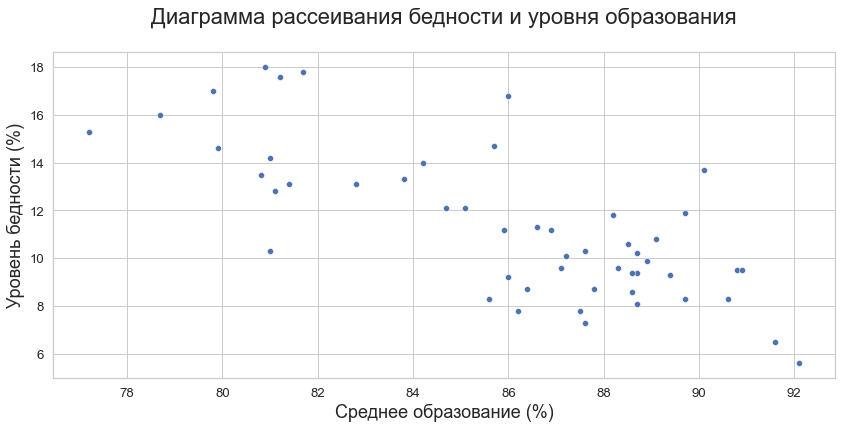

In [236]:
# Диаграмма рассеивания
sp = sns.scatterplot(x=graduation, y=poverty )
sets_for_plot(sp, 
              title='Диаграмма рассеивания бедности и уровня образования\n',
              xlabel='Среднее образование (%)',
              ylabel='Уровень бедности (%)')

In [237]:
# Расчет корреляции Пирсона 
rvalue, pvalue = stats.pearsonr(graduation, poverty)
print('Коэффициент корреляции =', round(rvalue, 2))
print('При p-значении = ', round(pvalue, 2))

Коэффициент корреляции = -0.75
При p-значении =  0.0


По графику видно, что взаимосвязь переменных можно описать прямой. Сама взаимосвязь подтверждается довольно ваысоким коэффициентом корреляции при p-value = 0 (практически)

#### Для оценки остатков потребуется построить регрессию

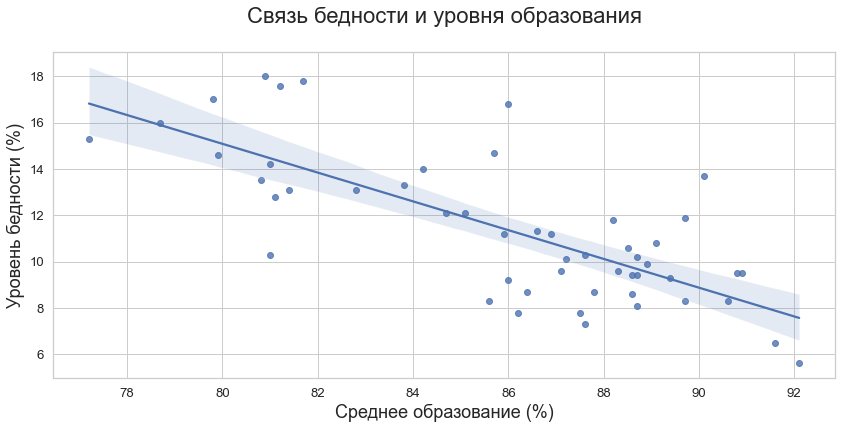

In [238]:
# График регрессии
reg = sns.regplot(x=graduation, y=poverty)
sets_for_plot(reg, 
              title='Связь бедности и уровня образования\n',
              xlabel='Среднее образование (%)',
              ylabel='Уровень бедности (%)')

In [239]:
# Преобразуем переменные для модели
poverty_y =  poverty.to_numpy()
graduation_x = graduation.to_numpy().reshape(-1,1)

In [240]:
# Обучим модель линейной регрессии
model = LinearRegression().fit(graduation_x, poverty_y)

In [241]:
# Получение прогнозируемых значений и расчет остатков
y_pred = model.predict(graduation_x)
residuals = poverty_y-y_pred
residuals

array([-0.54575002, -0.19873114,  0.57699518,  3.4754667 , -1.60028996,
       -0.2790429 , -2.62450296, -1.5790429 ,  5.44367196, -0.06390977,
        0.18457691,  0.79671375,  1.81034874, -0.21844971, -2.40784135,
       -0.75782618, -0.34116457, -0.24422154,  1.79212831,  0.31640199,
       -3.06238129, -1.07298965, -0.06238129, -1.37751442,  3.26183171,
       -0.32752959,  4.8906605 ,  1.12551221, -3.30481473, -1.96690606,
       -3.4320847 ,  3.77244007,  1.52548187, -1.11392494,  2.84217382,
       -0.51086798,  3.15730694,  0.40276701, -2.15632804, -4.16241163,
       -1.08665497,  0.5209571 , -0.26241163, -1.52303516,  0.0558088 ,
        0.34520044, -1.53813795,  1.36944379,  0.10878992, -1.14116457,
        1.18763388])

#### Проверка остатков регрессии на нормальность и гомоскедастичность

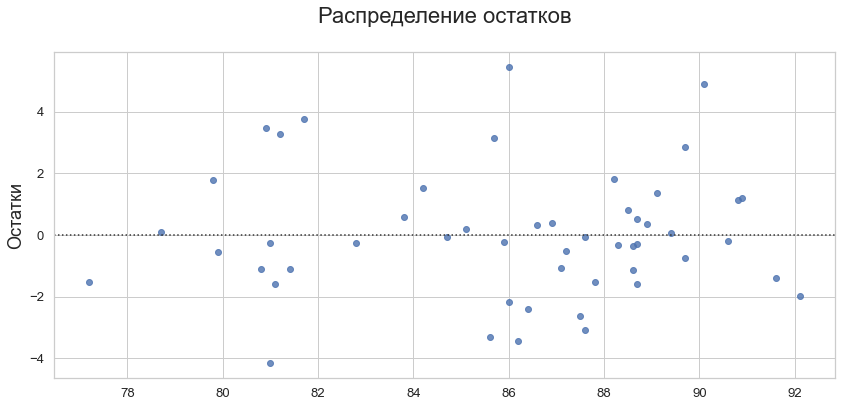

In [242]:
# График распределения остатков вокруг регрессионнной прямой
res = sns.residplot(x=graduation, y=poverty)
sets_for_plot(res, 
              title='Распределение остатков\n',
              ylabel='Остатки')

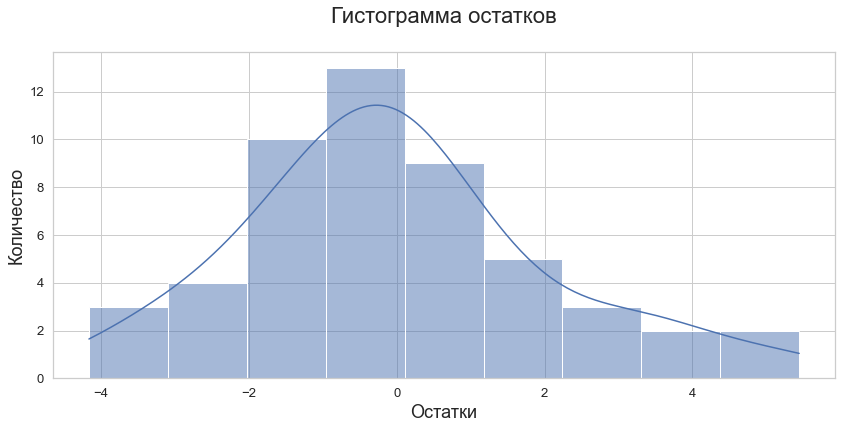

In [243]:
# Гистограмма остатков
hs = sns.histplot(x=residuals, kde=True)
sets_for_plot(hs, 
              title='Гистограмма остатков\n',
              xlabel='Остатки',
              ylabel='Количество')

В целом распределение остатков соответствует нормальному и разброс около регрессионной прямой довольно хаотичен (в среднем половина сверху прямой, половина снизу). Значит модель с одной независимой переменной может использоваться для прогнозирования и оценки взаимосвязи двух переменных.

In [244]:
# Результаты
print('b0 =', model.intercept_)
print('b1 =', model.coef_[0])
print('Коэфффициент детерминации = ', model.score(graduation_x, poverty_y))

b0 = 64.78096577010209
b1 = -0.6212167177940106
Коэфффициент детерминации =  0.5577972503105938


Используя всего одну переменную мы уже смогли описать 55% изменчивости фактора уровень бедности.

# 3. Оценка влияния всех независимых факторов на уровень бедности

Посмотрим как изменится коэффициент детерминации при включении всех параметров в модель

In [245]:
states_data.head()

,state,metro_res,white,hs_grad,poverty,female_house
0,Alabama,55.4,71.3,79.9,14.6,14.2
1,Alaska,65.6,70.8,90.6,8.3,10.8
2,Arizona,88.2,87.7,83.8,13.3,11.1
3,Arkansas,52.5,81.0,80.9,18.0,12.1
4,California,94.4,77.5,81.1,12.8,12.6


In [246]:
# Подготовка данных
x = states_data[['metro_res', 'white', 'hs_grad', 'female_house']]
y = states_data['poverty']

In [247]:
# Добавим константу для интерцепта
x = sm.add_constant(x)
x.head()

,const,metro_res,white,hs_grad,female_house
0,1.0,55.4,71.3,79.9,14.2
1,1.0,65.6,70.8,90.6,10.8
2,1.0,88.2,87.7,83.8,11.1
3,1.0,52.5,81.0,80.9,12.1
4,1.0,94.4,77.5,81.1,12.6


In [248]:
# Обучение модели
model = sm.OLS(y,x).fit()

In [249]:
print('Исправленный R-квадрат:', model.rsquared_adj)

model.params

Исправленный R-квадрат: 0.6104086194352505


const           66.476525
metro_res       -0.056323
white           -0.048144
hs_grad         -0.554713
female_house     0.050543
dtype: float64

Включение всех переменных в качестве независимых улучшило нашу модель. В данный момент Исправленный коэффициент детерминации равен 61%

# 4. Улучшение модели

Изучим зависимости между независимыми переменными и их статистическую значимость 

#### Проверка p-value

In [250]:
# Получение p-values
model.pvalues

const           0.000003
metro_res       0.006004
white           0.152156
hs_grad         0.000003
female_house    0.836350
dtype: float64

Видно, что у двух факторов pvalue выше порогового значения. Коэффициенты этих факторов также довольно малы.

#### Проверка мультиколлинеарности

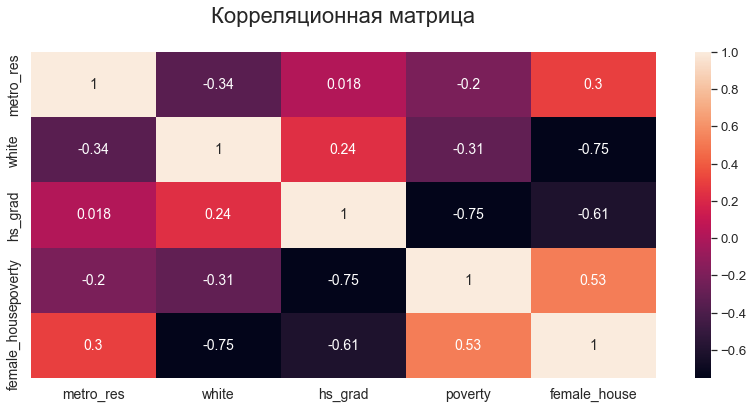

In [251]:
# Корреляционная матрица
hm = sns.heatmap(states_data.corr(), annot=True, annot_kws={'size': 14})
sets_for_plot(hm,
              title='Корреляционная матрица\n')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Видно, что параметр female_house сильно коррелирует сразу с несколькими переменными, плюс pvalue параметра говорит о его статистической незначимости. Поэтому проверим предположение, что модель станет лучше, если убрать эту переменную

In [252]:
x.drop(columns='female_house', inplace=True)

In [253]:
# Обучение модели
model = sm.OLS(y,x).fit()

In [257]:
print('Исправленный R-квадрат:', model.rsquared_adj)

model.params

Исправленный R-квадрат: 0.6183400750744104


const        68.722015
metro_res    -0.055532
white        -0.053327
hs_grad      -0.569724
dtype: float64

In [258]:
model.pvalues.round(3)

const        0.000
metro_res    0.005
white        0.017
hs_grad      0.000
dtype: float64

Модель стала лучше, т.к. увеличилось значение исправленного R-квадрата. Плюс у переменной "white" значение pvalue теперь не превышает уровня 0.05.

# 5. Вывод

Для лучшего описания значимости и дальнейшего прогнозирования уровня бедности при помощи линейной регрессии необходимо использовать три независимые переменные: metro_res, white, hs_grad. Изменчивость зависимой переменной будет объясняться на 62%